<a href="https://colab.research.google.com/github/Masakinka/python_for_ds_task/blob/main/HW_2_7_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [248]:
# # directory cleaner
# import shutil
# directory = './bank-customer-churn-prediction-dlu'
# # Check if the directory exists
# if os.path.exists(directory):
#     # Remove the directory and all its contents
#     shutil.rmtree(directory)
#     print(f"Directory {directory} has been cleared.")
# else:
#     print(f"Directory {directory} does not exist.")

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
!pip install pyarrow --quiet

In [62]:
import opendatasets as od
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score

In [4]:
pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [5]:
od.version()

'0.1.22'

In [6]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/'

In [7]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: viktoriiabortnikova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 85.9MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [8]:
data_dir = './bank-customer-churn-prediction-dlu'

In [9]:
os.listdir(data_dir)

['train.csv', 'test.csv', 'sample_submission.csv']

In [10]:
train_csv = data_dir + '/train.csv'

In [11]:
sample_submission = data_dir + '/sample_submission.csv'

In [12]:
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv')
raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.00,Nwankwo,678.00,France,Male,29.00,4.00,0.00,3.00,1.00,0.00,180626.36,0.00
1,1,15650086.00,Ch'in,687.00,France,Female,34.00,1.00,0.00,2.00,0.00,1.00,63736.17,0.00
2,2,15733602.00,Thompson,682.00,France,Female,52.00,6.00,0.00,3.00,0.00,0.00,179655.87,1.00
3,3,15645794.00,Macleod,753.00,Germany,Male,44.00,6.00,83347.25,2.00,1.00,0.00,161407.48,0.00
4,4,15633840.00,Hsia,544.00,Germany,Female,55.00,0.00,107747.57,1.00,1.00,0.00,176580.86,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.00,Ch'iu,585.00,France,Male,33.00,3.00,0.00,1.00,1.00,0.00,54191.38,0.00
14996,14996,15731781.00,Ch'ang,678.00,France,Male,34.00,6.00,0.00,2.00,1.00,1.00,53437.10,0.00
14997,14997,15667093.00,Goliwe,678.00,France,Female,54.00,4.00,0.00,1.00,1.00,0.00,147720.29,1.00
14998,14998,15732644.00,Fanucci,705.00,Spain,Female,40.00,7.00,0.00,2.00,1.00,0.00,149550.95,0.00


In [13]:
raw_df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [14]:
raw_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,7499.50,15691456.68,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67,0.20
std,4330.27,135205.03,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45,0.40
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,3749.75,15635143.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14,0.00
50%,7499.50,15690175.00,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87,0.00
75%,11249.25,15757181.50,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70,0.00
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.00


In [15]:
raw_df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [16]:
# check for fractional results in these columns
fractional_values_check = {
    'Age': raw_df[raw_df['Age'] % 1 != 0].shape[0],
    'CreditScore':  raw_df[raw_df['CreditScore'] % 1 != 0].shape[0],
    'CustomerId':  raw_df[raw_df['CustomerId'] % 1 != 0].shape[0],
    'Tenure': raw_df[raw_df['Tenure'] % 1 != 0].shape[0],
    'NumOfProducts': raw_df[raw_df['NumOfProducts'] % 1 != 0].shape[0],
    'HasCrCard': raw_df[raw_df['HasCrCard'] % 1 != 0].shape[0],
    'IsActiveMember': raw_df[raw_df['IsActiveMember'] % 1 != 0].shape[0],
    'Exited': raw_df[raw_df['Exited'] % 1 != 0].shape[0],
}
fractional_values_check

{'Age': 0,
 'CreditScore': 0,
 'CustomerId': 0,
 'Tenure': 0,
 'NumOfProducts': 0,
 'HasCrCard': 0,
 'IsActiveMember': 0,
 'Exited': 0}

In [17]:
# Correct data types
raw_df['CustomerId'] = raw_df['CustomerId'].astype(int)
raw_df['CreditScore'] = raw_df['CreditScore'].astype(int)
raw_df['Age'] = raw_df['Age'].astype(int)
raw_df['Tenure'] = raw_df['Tenure'].astype(int)
raw_df['Exited'] = raw_df['Exited'].astype(int)
raw_df['NumOfProducts'] = raw_df['NumOfProducts'].astype(int)
raw_df['HasCrCard'] = raw_df['HasCrCard'].astype(int)
raw_df['IsActiveMember'] = raw_df['IsActiveMember'].astype(int)

In [18]:
# Split the data into features and target
X = raw_df.drop('Exited', axis=1)
y = raw_df['Exited']

# Split the data into training and validation sets with stratification
# This parameter indicates that the data split should be stratified according to the variable y.
# This means that the distribution of classes in the training and validation sets will be similar
# to the distribution of classes in the original dataset. This is important if you have imbalanced classes.
# train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display the shapes of the splits
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

# Display the first few rows of the training set
print(X_train.head())
print(y_train.head())

Training set shape: (12000, 13), (12000,)
Validation set shape: (3000, 13), (3000,)
          id  CustomerId    Surname  CreditScore Geography  Gender  Age  Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
7180    7180    15652218       Mays          682    France    Male   30       1 131394.56              1          1               1        143952.24
10393  10393    15592937     Ch'eng          684    France  Female   39       2 178058.06              1          1               0        145518.31
80        80    15774586      Ch'in          705   Germany    Male   35       6 116320.68              2          1               0        174431.01
3365    3365    15780572         K?          669     Spain    Male   58       0      0.00              2          0               1         51565.98
12236  12236    15642099  Trevisani          707    France    Male   21       3      0.00              2          1               1        148564.76
7180     0
10393    0


*Customer ID: Унікальний ідентифікатор для кожного клієнта (це поле містить дублікати для різної інформації клієнтів, тому його просто видаляємо)*

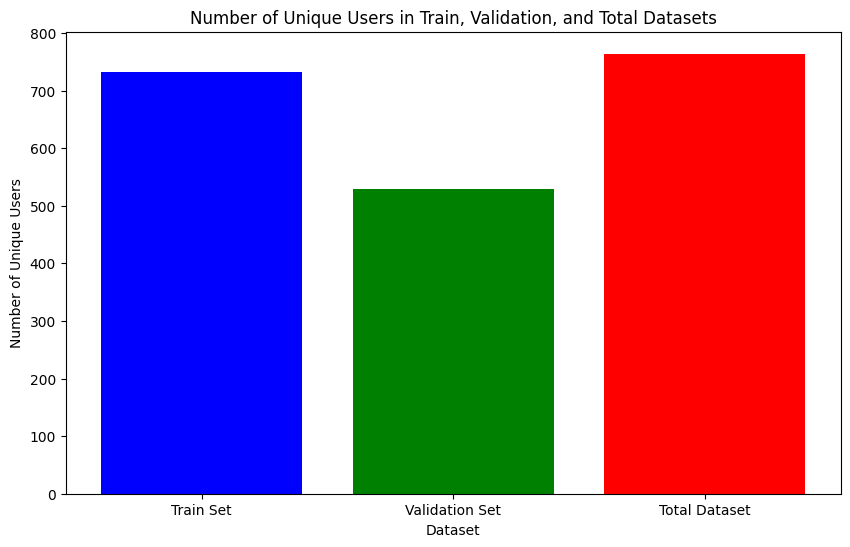

In [19]:
# Check for unique users based on 'Surname'
train_unique_users = X_train['Surname'].nunique()
val_unique_users = X_val['Surname'].nunique()
total_unique_users = raw_df['Surname'].nunique()

# Create a bar plot
labels = ['Train Set', 'Validation Set', 'Total Dataset']
unique_users_counts = [train_unique_users, val_unique_users, total_unique_users]

plt.figure(figsize=(10, 6))
plt.bar(labels, unique_users_counts, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users in Train, Validation, and Total Datasets')
plt.show()

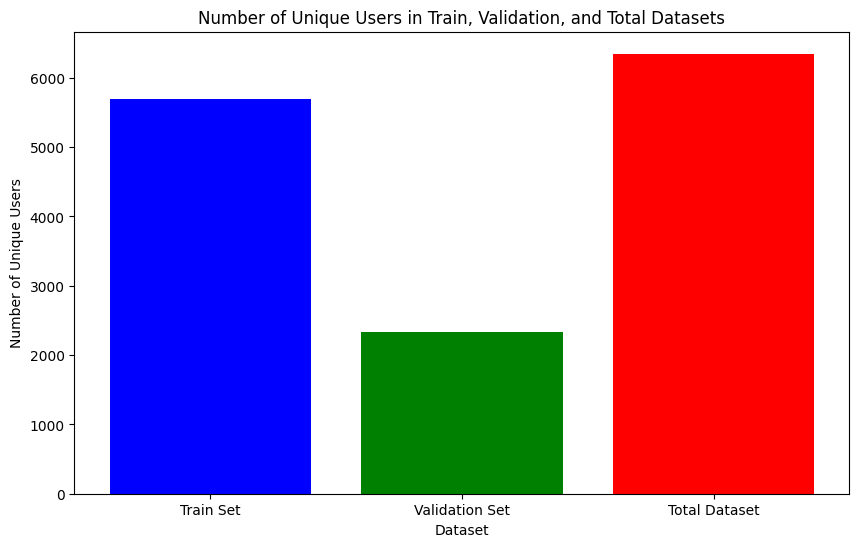

In [20]:
# Check for unique users based on 'CustomerId'
train_unique_users = X_train['CustomerId'].nunique()
val_unique_users = X_val['CustomerId'].nunique()
total_unique_users = raw_df['CustomerId'].nunique()

# Create a bar plot
labels = ['Train Set', 'Validation Set', 'Total Dataset']
unique_users_counts = [train_unique_users, val_unique_users, total_unique_users]

plt.figure(figsize=(10, 6))
plt.bar(labels, unique_users_counts, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users in Train, Validation, and Total Datasets')
plt.show()

In [21]:
train_unique_users,val_unique_users,total_unique_users

(5700, 2327, 6348)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

В минулому завданні використано метод train_test_split з параметром stratify, тому розподіл значень цільової змінної (у цьому - 'Exited') буде однаковим у тренувальному та валідаційному наборах даних.
Тому оскільки параметр stratify вже визначає, що розподіл залежить від цільової змінної, окреме визначення списків для вхідних змінних (input_cols) та цільової змінної (target_col) не потрібно для розділення даних.


In [271]:
#input_cols = list(X_train.columns)[1:-1]
#target_col = 'Exited'

In [22]:
# Create the specified datasets
train_inputs = X_train.copy()
train_targets = y_train.copy()
val_inputs = X_val.copy()
val_targets = y_val.copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [23]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [24]:
numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

In [25]:
train_inputs[numeric_cols].describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,7479.63,15690923.99,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,4334.09,146930.97,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,3725.75,15635116.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,7471.50,15689953.00,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,11231.25,15756921.50,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [26]:
train_inputs[categorical_cols].nunique()

Surname      732
Geography      3
Gender         2
dtype: int64

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

Пункт по заповненню пропущених значень робити не будемо, бо ще на етапі аналізу перевірили, що таких немає.

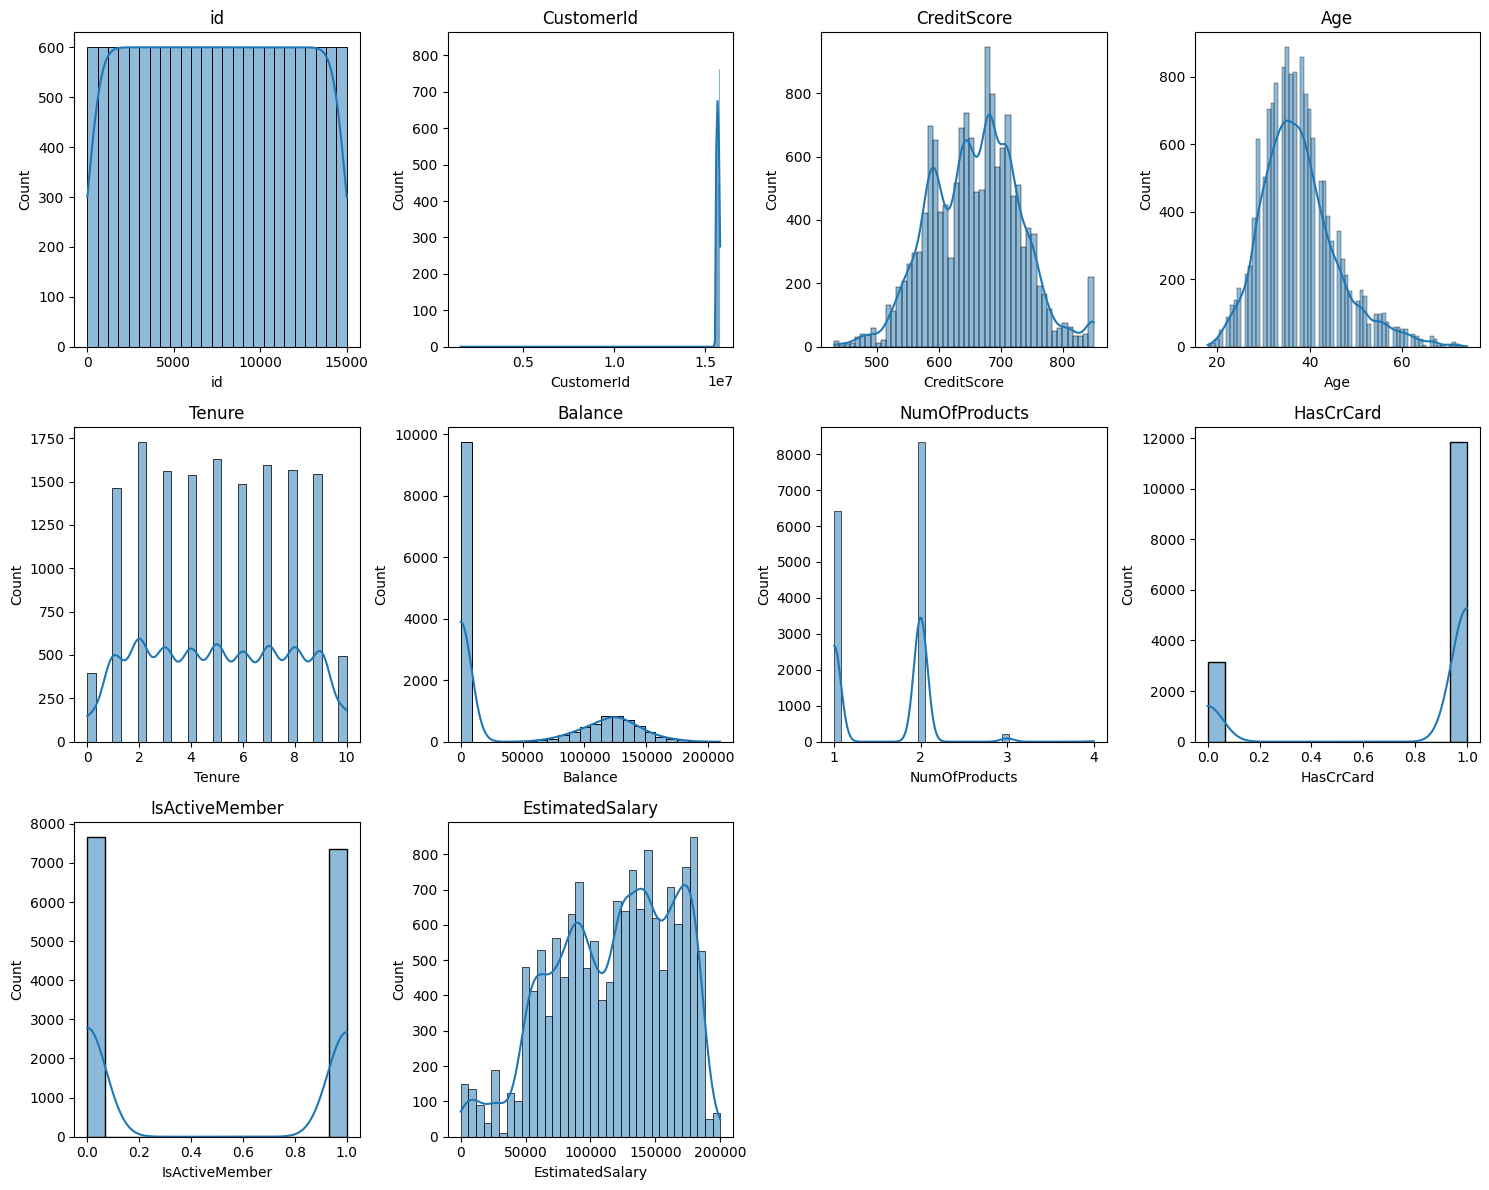

In [27]:
# Visualization of numerical data distribution
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i + 1)
    sns.histplot(raw_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [28]:
# Analysis of categorical data
for col in categorical_cols:
    print(f"Distribution of values in the column {col}: {col}:")
    print(raw_df[col].value_counts())

Distribution of values in the column Surname: Surname:
Surname
Ch'iu      252
Ch'ien     241
Ch'ang     225
Hsia       204
T'ien      187
          ... 
Trejo        1
Purdy        1
Otoole       1
Sarratt      1
Liardet      1
Name: count, Length: 764, dtype: int64
Distribution of values in the column Geography: Geography:
Geography
France     9032
Spain      3303
Germany    2665
Name: count, dtype: int64
Distribution of values in the column Gender: Gender:
Gender
Male      8529
Female    6471
Name: count, dtype: int64


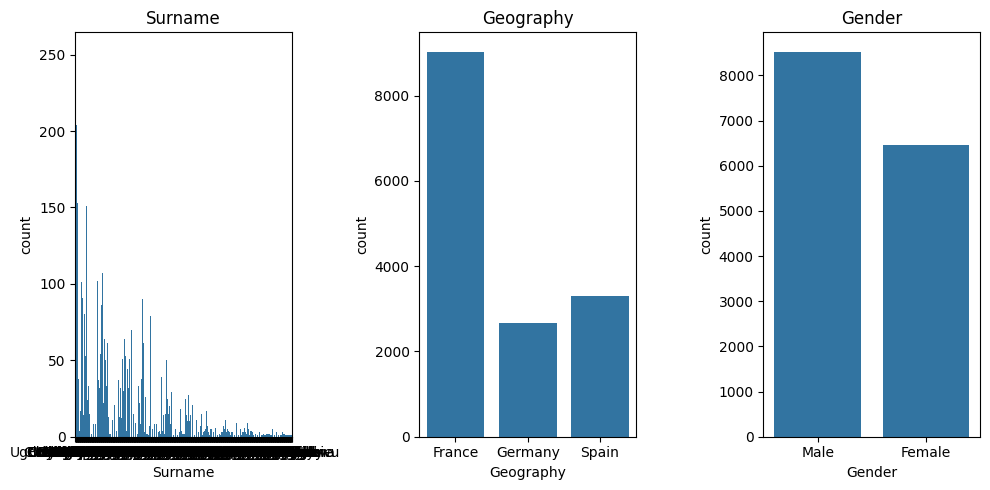

In [29]:
# Visualization of categorical data distribution
plt.figure(figsize=(10, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=raw_df, x=col)
    plt.title(col)
plt.tight_layout()
plt.show()

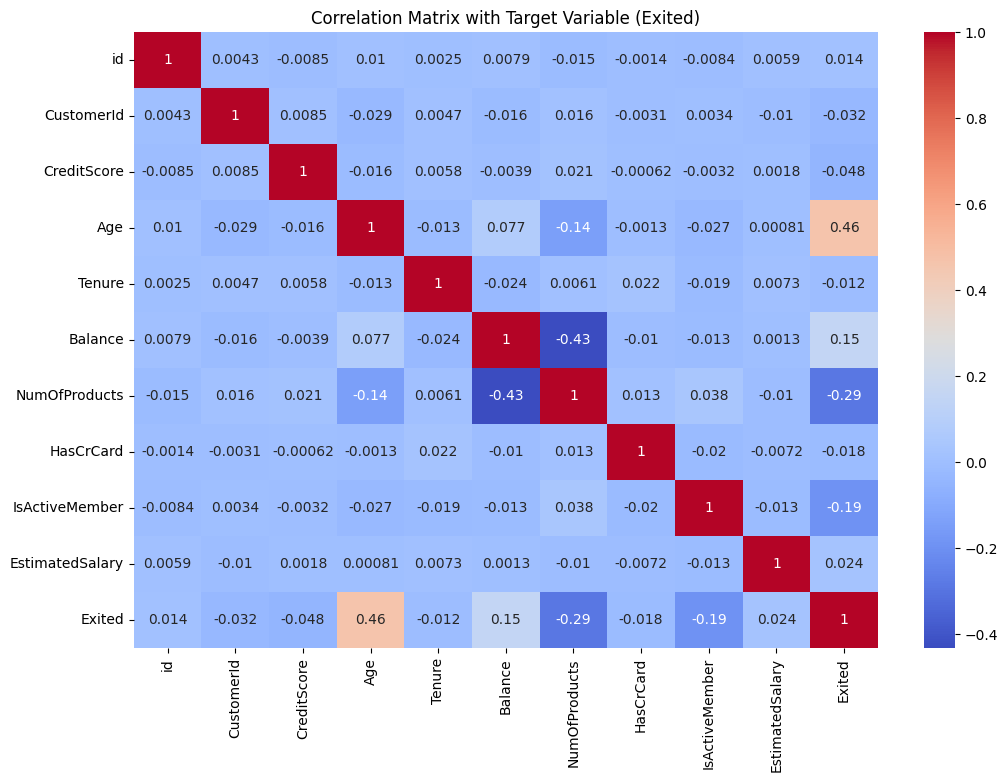

Feature: Geography, p-value: 2.3828579577437346e-192
Feature: Gender, p-value: 8.217517615834431e-100


In [30]:
# Check correlation of numerical variables with the target function
numerical_features = raw_df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude the target variable
numerical_features.remove('Exited')

# Calculate the correlation
correlation_matrix = raw_df[numerical_features + ['Exited']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Target Variable (Exited)')
plt.show()

# Check correlation of categorical variables with the target function
categorical_features = raw_df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Surname')  # Виключаємо Surname

# Function to compute statistical significance using chi-square test
def chi_square_test(feature, target):
    contingency_table = pd.crosstab(raw_df[feature], raw_df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return p

# Print the results of the chi-square test
for feature in categorical_features:
    p_value = chi_square_test(feature, 'Exited')
    print(f"Feature: {feature}, p-value: {p_value}")

# p-value менше 0.05 вказує на статистично значущий зв'язок змінної з цільовою функцією
#numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
#categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Age: 0,46 — це досить сильна позитивна кореляція, яка означає, що зі збільшенням віку клієнтів збільшується ймовірність їх уходу.

Balance і NumOfProducts: ці змінні мають кореляцію приблизно -0,43 із змінною "Вихід". Це вказує на те, що більш високий баланс і більша кількість продуктів, на оборот, пов'язані з меншою ймовірністю уходу клієнтів.

IsActiveMember: -0.19 — це помірна негативна кореляція, яка показує, що активні учасники схильні режисувати.

Останні змінні показують менш значущу кореляцію з змінною "Exited".

хі-квадрати тесту для категоріальних параметрів "Geography" і "Gender" вказують на те, що ці параметри статистично значимі пов'язані з цільовим параметром "Вийшов". Значення p-value для цих змінних набагато менше стандартного порога 0,05

Переходимо до масштабування числових даних та кодування категоріальних даних 'Geography', 'Gender'. для підготовки даних до моделі. Спробуємо одразу написати пайплайн обробки.

Виключення стовпця id, CustomerId та Surname:
1. Стовпець id є унікальним ідентифікатором кожного рядка у вашому наборі даних. Він не несе корисної інформації для моделі, оскільки не має кореляції з цільовою змінною. Використання цього стовпця може навіть зашкодити моделі, оскільки модель може вивчити неправдиві залежності від унікальних значень id.
2. Стовпець CustomerId також є унікальним ідентифікатором кожного клієнта. Як і id, він не несе корисної інформації для прогнозування. Використання цього стовпця може призвести до надмірного підлаштування (overfitting), коли модель вивчає залежності, які не мають сенсу для нових даних.
3. Стовпець Surname є категоріальною змінною, яка не має безпосередньої кореляції з цільовою змінною. Прізвища можуть бути унікальними або рідкісними, і їх кодування може призвести до надмірного підлаштування, що погіршить узагальнення моделі.

Висновок: Ми виключаємо id, CustomerId та Surname з передобробки даних, щоб зосередитися на значущих ознаках, які можуть впливати на відтік клієнтів.

In [33]:
# Define categorical and numerical colum to predprocessing
#numeric_cols_transform = [col for col in numeric_cols if col not in ['id', 'CustomerId']]
numeric_cols_transform = [col for col in numeric_cols if col not in ['id', 'CustomerId','CreditScore','Tenure','HasCrCard','EstimatedSalary']]
categorical_cols_transform = [col for col in categorical_cols if col not in ['Surname']]

# Create a pipeline for numerical data (scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


# Create a pipeline for categorical data (encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_transform),
        ('cat', categorical_transformer, categorical_cols_transform)])

In [34]:
# Apply preprocessing to the training and validation datasets
train_inputs_processed = preprocessor.fit_transform(train_inputs)
val_inputs_processed = preprocessor.transform(val_inputs)

In [35]:
# Getting the names of encoded categorical features
encoded_cat_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_transform)

# Converting back to DataFrame for easy viewing
train_inputs_processed_df = pd.DataFrame(train_inputs_processed, columns=numeric_cols_transform + list(encoded_cat_cols))
val_inputs_processed_df = pd.DataFrame(val_inputs_processed, columns=numeric_cols_transform + list(encoded_cat_cols))

In [36]:
# Display the first rows of the processed data
print("Processed Train Inputs:")
display(train_inputs_processed_df.head())
print("Processed Validation Inputs:")
display(val_inputs_processed_df.head())

Processed Train Inputs:


,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.94,1.48,-1.11,1.02,1.00,0.00,0.00,0.00,1.00
1,0.16,2.25,-1.11,-0.98,1.00,0.00,0.00,1.00,0.00
2,-0.33,1.22,0.77,-0.98,0.00,1.00,0.00,0.00,1.00
3,2.50,-0.72,0.77,1.02,0.00,0.00,1.00,0.00,1.00
4,-2.05,-0.72,0.77,1.02,1.00,0.00,0.00,0.00,1.00


Processed Validation Inputs:


,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1.02,1.21,4.52,1.02,0.00,1.00,0.00,0.00,1.00
1,0.41,-0.72,0.77,1.02,1.00,0.00,0.00,0.00,1.00
2,0.04,-0.72,0.77,1.02,1.00,0.00,0.00,1.00,0.00
3,0.65,1.88,-1.11,1.02,1.00,0.00,0.00,1.00,0.00
4,-0.94,-0.72,0.77,-0.98,0.00,0.00,1.00,1.00,0.00


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [37]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 13)
train_targets: (12000,)
val_inputs: (3000, 13)
val_targets: (3000,)


In [38]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [39]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: user 10.5 ms, sys: 3 ms, total: 13.5 ms
Wall time: 17.2 ms


In [40]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')

CPU times: user 43.1 ms, sys: 6.02 ms, total: 49.1 ms
Wall time: 82.8 ms


In [41]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 13)
train_targets: (12000,)
val_inputs: (3000, 13)
val_targets: (3000,)


In [42]:
val_inputs

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6490,6490,15794345,Pirozzi,714,Germany,Male,46,1,115764.32,4,1,1,72945.32
3646,3646,15617348,Ritchie,593,France,Male,41,5,0.00,2,1,1,38196.24
5306,5306,15787907,Hs?eh,731,France,Female,38,2,0.00,2,0,1,116971.05
652,652,15803378,Onio,673,France,Female,43,4,155739.76,1,0,1,111622.76
2627,2627,15772423,Genovesi,678,Spain,Female,30,4,0.00,2,1,0,143681.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10550,10550,15635388,Hsia,678,France,Male,38,4,0.00,2,1,0,133535.29
8866,8866,15589715,Ting,753,France,Male,54,6,0.00,1,1,0,177065.24
3244,3244,15682890,Okwuadigbo,678,Spain,Male,32,5,0.00,2,1,0,176712.59
12441,12441,15690188,Aitken,724,Spain,Male,33,5,138162.41,1,1,0,105720.09


In [43]:
val_targets

6490     1
3646     0
5306     0
652      0
2627     0
        ..
10550    0
8866     1
3244     0
12441    0
3024     0
Name: Exited, Length: 3000, dtype: int64

In [44]:
!ls

bank-customer-churn-prediction-dlu  train_inputs.parquet   val_inputs.parquet
sample_data			    train_targets.parquet  val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [45]:
# Creating X_train and X_val from prepared data
X_train = train_inputs_processed_df
X_val = val_inputs_processed_df

# Training the LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predicting on the validation set
y_val_pred = model.predict(X_val)

# Evaluating the model
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2390
           1       0.73      0.57      0.64       610

    accuracy                           0.87      3000
   macro avg       0.81      0.76      0.78      3000
weighted avg       0.86      0.87      0.86      3000

Confusion Matrix:
[[2258  132]
 [ 260  350]]


1. Клас 0 (не втрачені клієнти):
Precision: 0.90 — це означає, що коли модель передсказує клас 0, вона правильно робить це в 90% випадків.
Recall: 0.94 — це означає, що модель успішно ідентифікує 94% усіх істинних випадків класу 0. (трохи вище значення порывнянно з минулим способом обробки даних)
F1-Score: 0.92 — середня гармонічна точність і запам'ятовування, хороший показник балансу між ними.
2. Клас 1 (втрачені клієнти):
Precision: 0.73 — коли модель передсказує клас 1, вона правильно робить це в 73% випадків.
Відкликання: 0,57 — модель успішно ідентифікує лише 57% усіх істинних випадків класу 1.
F1-Score: 0.64 — відносно низький показник, що вказує на більш слабку продуктивність моделі в ідентифікації втрачених клієнтів.
3. Матриця:
[2258, 132]: З 2390 клієнтів, які не пішли, модель правильно ідентифікувала 2258 як клієнтів,шо не пішли і помилково визначила 132 як тих, що пішли.
[260, 350]: З 610 втрачених клієнтів модель правильно ідентифікувала лише 350 як втрачених, і помилково визначила 260 як, які не пішли
4. Загальна точність:
Точність: 0,87 — загальний відсоток правильно класифікованих випадків з усіх прикладів.

Модель добре працює з визначенням не втрачених клієнтів, але її здатність ідентифікувати втрачених клієнтів можна покращити.
Низьке відкликання для класу втрачених клієнтів може бути визвано нехваткою даних про таких клієнтів або недостатньо потужними визнаннями в даних для їх ідентифікації.


In [54]:
X_train.head()

,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.94,1.48,-1.11,1.02,1.00,0.00,0.00,0.00,1.00
1,0.16,2.25,-1.11,-0.98,1.00,0.00,0.00,1.00,0.00
2,-0.33,1.22,0.77,-0.98,0.00,1.00,0.00,0.00,1.00
3,2.50,-0.72,0.77,1.02,0.00,0.00,1.00,0.00,1.00
4,-2.05,-0.72,0.77,1.02,1.00,0.00,0.00,0.00,1.00


In [55]:
model.coef_.round(2)

array([[ 1.29, -0.32, -0.72, -0.64, -0.49,  1.09, -0.59,  0.43, -0.43]])

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [56]:
# Predict on training set for further metric calculations
y_train_pred = model.predict(X_train)
y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_val)[:, 1]

# Compute metrics
from sklearn.metrics import f1_score, roc_auc_score
train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)
train_auc = roc_auc_score(y_train, y_train_probs)
val_auc = roc_auc_score(y_val, y_val_probs)

# Print results
print(f"F1 Score on training data: {train_f1}")
print(f"F1 Score on validation data: {val_f1}")
print(f"AUROC on training data: {train_auc}")
print(f"AUROC on validation data: {val_auc}")

F1 Score on training data: 0.6366022429014554
F1 Score on validation data: 0.6410256410256409
AUROC on training data: 0.8811360367386732
AUROC on validation data: 0.8784652582481651


1.F1 Score:

На тренувальних даних: 0.6366
На валідаційних даних: 0.6410
F1 score поєднує precision та recall в одну метрику, яка оцінює баланс між ними. Значення F1 близько 0.64 на обох наборах даних вказують на достатньо збалансовану, але не ідеальну якість класифікації, особливо для позитивного класу. Це може бути показником, що модель справляється з завданням краще, ніж випадкова класифікація, але є потенціал для поліпшення.

2. AUROC:

На тренувальних даних: 0.8811
На валідаційних даних: 0.8747
Значення AUROC вище 0.87 свідчать про добру якість класифікації моделі, здатності розрізняти класи. AUROC, близький до 1.0, вказує на високу ймовірність того, що модель правильно класифікує випадково обраний позитивний приклад вище випадково обраного негативного прикладу.

In [49]:
# Confusion Matrix
print("Confusion Matrix на тренувальних даних:")
print(confusion_matrix(y_train, y_train_pred))
print("Confusion Matrix на валідаційних даних:")
print(confusion_matrix(y_val, y_val_pred))

Confusion Matrix на тренувальних даних:
[[9143  415]
 [1108 1334]]
Confusion Matrix на валідаційних даних:
[[2258  132]
 [ 260  350]]


Ці результати показують, що модель має відносно високу здатність визначати н\ клієнтів, що не пішли (TN) і помірну здатність правильно ідентифікувати клієнтів, які пішли (TP), проте кількість помилок другого типу (FN), де клієнти, що пішли, були помилково визначені як клієнти,що залишились, варто знизити. Також варто звернути увагу на помилки першого типу (FP), де клієнти, що не пішли були помилково визначені як ті, що пішли.

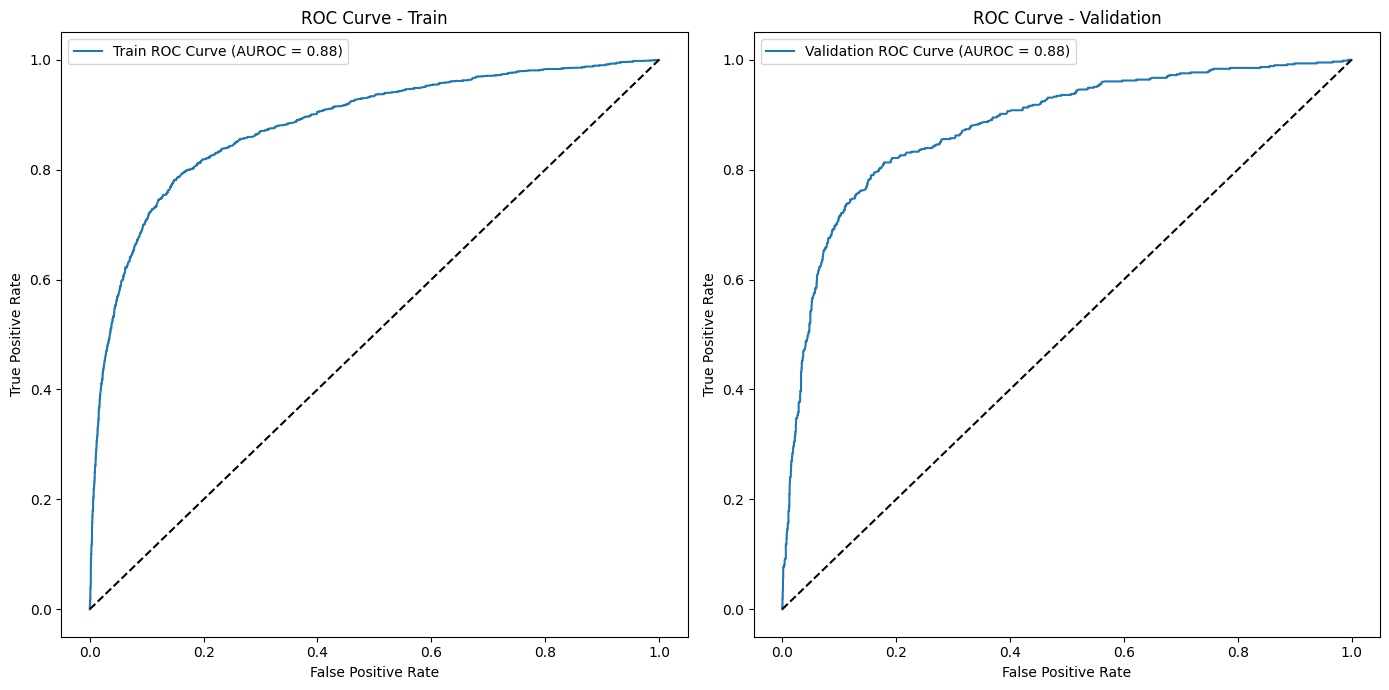

In [50]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUROC = {train_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, label=f'Validation ROC Curve (AUROC = {val_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

1. Оцінка кривих ROC:
- Значення AURO як для тренувальних, так валідаційних даних становить 0.88. Це відмінний результат, що вказує на високу здатність моделі розрізняти між класами.
- Обидві криві піднімаються досить швидко до лівого верхнього кута, що вказує на високу чутливість і специфічність моделі. Це означає, що модель з високою ймовірністю правильно визначає як позитивні, і негативні випадки.
- Оскільки криві та площі під кривими (AUROC) дуже близькі для обох наборів даних, це говорить про те, що модель має гарну узагальнюючу здатність і не перенавчена.

2. AUROC 0.88 вказує на чудову продуктивність моделі. В ідеалі значення AUROC близькі до 1.0 означають ідеальну здатність моделі розрізняти два класи. Значення 0.88 говорить про те, що модель дуже добре справляється із цим завданням.
3. Висновки:
Криві ROC та показники AUROC показують, що модель ефективно розрізняє між класами і її можна вважати надійною для прогнозування відтоку клієнтів.



Загальні висновки:

 1. **Производительность по F1 Score і AUROC**
- **F1 Score** на тренувальних і валідаційних даних знаходиться на рівні близько 0.64. Це не найвищий показник, особливо для сценаріїв, де критично важливо максимально точно ідентифікувати позитивні випадки (наприклад, клієнтів, які пішли). Це вказує на те, що модель має потенціал для покращення, особливо в плані балансу між чутливістю та специфічністю.
- **AUROC** знаходиться на дуже високому рівні 0.88 для обох тренувальних і валідаційних даних, що свідчить про високу здатність моделі правильно класифікувати обидва класи та добре їх розрізняти.

2. **Согласованность між тренувальними і валідаційними даними**
Модель демонструє стабільність метрик між тренувальними та валідаційними даними, що є позитивним індикатором її обобщаючої спроможності. Це означає, що модель не перенавчена і добре працює з новими даними.

3. **Аналіз матриць**
Матриці показують, що модель краще ідентифікує клієнтів, які не пішли ніж тих, що пвшли, що зазвичай є типовим для дисбалансованих даних. Однак помилки в ідентифікації клієнтів, які пвшли (False Negatives) можуть бути критичними в залежності від бізнес-задач.


4. Модель можна вважати **задовільною** із тенденцією до «хорошої» з огляду на високий AUROC і стабільність метрик. Вона вже зараз може бути корисною для ідентифікації потенційних клієнтів, що пішли, однак існує потенціал для подальшого покращення. Зокрема, варто зосередитися на покращенні F1 score, особливо шляхом підвищення чутливості до класу клієнтів, що пішли. Це можна досягти через перебалансування даних, налаштування порогу класифікації, або використання більш складних моделей машинного навчання.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [57]:
# Determining the majority class in training data
majority_class = y_train.mode()[0]
print(f"Мажоритарний клас: {majority_class}")

Мажоритарний клас: 0


In [58]:
# Creating predictions for the base model
y_train_majority_pred = np.full_like(y_train, majority_class)
y_val_majority_pred = np.full_like(y_val, majority_class)

In [59]:
# Calculating accuracy for the base model
train_majority_accuracy = accuracy_score(y_train, y_train_majority_pred)
val_majority_accuracy = accuracy_score(y_val, y_val_majority_pred)

# Calculating accuracy for the trained model
train_model_accuracy = accuracy_score(y_train, y_train_pred)
val_model_accuracy = accuracy_score(y_val, y_val_pred)

# Outputting results
print(f"Accuracy базової моделі на тренувальних даних: {train_majority_accuracy}")
print(f"Accuracy базової моделі на валідаційних даних: {val_majority_accuracy}")
print(f"Accuracy натренованої моделі на тренувальних даних: {train_model_accuracy}")
print(f"Accuracy натренованої моделі на валідаційних даних: {val_model_accuracy}")

Accuracy базової моделі на тренувальних даних: 0.7965
Accuracy базової моделі на валідаційних даних: 0.7966666666666666
Accuracy натренованої моделі на тренувальних даних: 0.8730833333333333
Accuracy натренованої моделі на валідаційних даних: 0.8693333333333333


Натренована модель демонструє значно кращу продуктивність порівняно з базовою моделлю. Висока точність на обох наборах даних (тренувальних та валідаційних) свідчить про те, що модель добре навчається на тренувальних даних і здатна узагальнювати на нові дані.
Значення F1 Score та AUROC також вказують на хорошу продуктивність моделі.
Точність на тренувальних та валідаційних даних досить схожа, що свідчить про те, що модель не має значного переобучення. Це є позитивним знаком, оскільки модель не просто запам'ятала тренувальні дані, але й здатна узагальнювати нові.Однак, F1 Score показує, що є певні помилки в передбаченні класу 1. Це може свідчити про те, що модель все ще може бути покращена, особливо для розпізнавання менш представленого класу.

дублюю висновок з попереднього пункту: *Модель можна вважати задовільною із тенденцією до «хорошої» з огляду на високий AUROC і стабільність метрик. Вона вже зараз може бути корисною для ідентифікації потенційних клієнтів, що пішли, однак існує потенціал для подальшого покращення. Зокрема, варто зосередитися на покращенні F1 score, особливо шляхом підвищення чутливості до класу клієнтів, що пішли. Це можна досягти через перебалансування даних, налаштування порогу класифікації, або використання більш складних моделей машинного навчання.*

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [63]:
# Define the model and the preprocessing details in a dictionary
churn_prediction = {
    'model': model,
    'preprocessor': preprocessor,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
}

# Save everything to a joblib file
joblib.dump(churn_prediction, 'log_reg.joblib')

['log_reg.joblib']

In [64]:
# Load the dictionary from the joblib file
churn_prediction_loaded = joblib.load('log_reg.joblib')

# Access the loaded model and assign it to model_2
model_2 = churn_prediction_loaded['model']
preprocessor_loaded = churn_prediction_loaded['preprocessor']
numeric_cols_loaded = churn_prediction_loaded['numeric_cols']
categorical_cols_loaded = churn_prediction_loaded['categorical_cols']

In [65]:
model_2

LogisticRegression(random_state=42)

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [60]:
#import warnings
#warnings.filterwarnings("ignore")

#def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
#    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
#    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
#    X_input = input_df[numeric_cols + encoded_cols]
#    prob = model.predict_proba(X_input)[:,1]
#    return prob

In [ ]:
#predict_input(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

In [66]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(model, preprocessor, input_df):
    """
    This function preprocesses the input data and predicts probabilities using the provided model.

    Parameters:
    model: The trained model used for predictions.
    preprocessor: The preprocessing pipeline for transforming the input data.
    input_df: The input DataFrame containing raw data to be predicted.

    Returns:
    prob: The predicted probabilities for the class 1 for each row in the input DataFrame.
    """

    # Apply the preprocessing pipeline to the input data
    X_processed = preprocessor.transform(input_df)

    # Predict probabilities for the processed data
    prob = model.predict_proba(X_processed)[:, 1]

    return prob

In [69]:
# Assuming `model_loaded` and `preprocessor_loaded` are the loaded model and preprocessor respectively
predictions = predict_raw_df(model_2, preprocessor_loaded, raw_df[:5])

In [70]:
predictions

array([0.00573488, 0.03180377, 0.34355628, 0.42766374, 0.97187884])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [72]:
# Load the input data from test.csv
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')

In [73]:
# Make predictions
predictions = predict_raw_df(model_2, preprocessor_loaded, test_raw_df)

# Add the predictions to the DataFrame
test_raw_df['Exited'] = predictions

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
# Load the sample submission file
submission_df =  pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')

# Ensure the 'Exited' column is filled with predictions
submission_df['Exited'] = predictions

# Save the updated DataFrame to a new CSV file
submission_df.to_csv('drive/MyDrive/Colab Notebooks/data//submission_log_reg.csv', index=False)

In [79]:
# Display the first 5 rows of the final dataset
print(submission_df.head())

      id  Exited
0  15000    0.06
1  15001    0.03
2  15002    0.17
3  15003    0.22
4  15004    0.05
